In [1]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import re
import sys
import matplotlib.colors as mcolors

In [2]:
import warnings
from pandas.errors import PerformanceWarning, SettingWithCopyWarning
warnings.filterwarnings('ignore', category=PerformanceWarning)
warnings.filterwarnings('ignore', category=SettingWithCopyWarning)
pd.set_option('future.no_silent_downcasting', True)

In [3]:
pd.options.display.float_format = '{:,.3f}'.format

In [4]:
sys.path.append('/Users/veronicabackerperal/Dropbox (Princeton)/Princeton/saving-glut/src')
from utils import *

In [5]:
sns.set_style('whitegrid')

# Set the custom color palette
custom_palette = sns.color_palette("Set2")
sns.set_palette(custom_palette)

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

linestyles = ['-', '--', '-.',':']
markers = ['o', 's', '^','v']

In [6]:
# Natural splits in time
max_year=2019
year_splits = [1963, 1983, 1998, 2008, 2020]
year5_splits = list(range(1963,2024, 5))

In [7]:
percentile_labels = {
    1 : 'Top 1%',
    9 : 'Next 9%',
    90 : 'Bottom 90%',
}

In [8]:
savings_cols=['DINAsaving2NI', 'CBOsaving2NI', 'FOFsaving2NI']

In [9]:
natinc = load_nipa_tables()[['Year','NationalInc']]

In [10]:
def load_data(file_name, folder='clean'):
    if file_name.endswith('.csv'):
        return pd.read_csv(os.path.join(data_folder, folder, file_name))
    elif file_name.endswith('.dta'):
        return pd.read_stata(os.path.join(data_folder, folder, file_name))
    else:
        print('Could not interpret file type.')
        return pd.DataFrame()

In [11]:
def collapse_data(df, splits=year_splits, groups=[]):
    df['Year_Group'] = pd.cut(df['Year'], bins=splits, labels=[f'{year}-{min(splits[i+1]-1, max_year)}' for i, year in enumerate(splits[:-1])], right=False)
    df = df.groupby(['Year_Group']+groups, observed=True).mean().reset_index()
    df['Year'] = df['Year_Group'].str.slice(0,4).astype(int)
    return df

In [12]:
def take_difference(df, base_year='', groups=[], cols=[], year_col='Year_Group'):
    # Take difference relative to 1978-1982 period
    df['temp'] = 1
    BY = df[df[year_col]==base_year][cols+['temp']+groups].rename(columns={col: f'{col}_BY' for col in cols})
    df = df.merge(BY, on=['temp']+groups)

    for col in cols:
        df[f'{col}_diff'] = df[col] - df[f'{col}_BY']
    
    return df

In [13]:
def save_table(table, file_name):
    with open(os.path.join(tables_folder, file_name), 'w') as f:
        f.write(table)

In [14]:
def add_cmidrule(latex_str, df):
    # Add in lines under the multiheaders
    headers = df.columns.get_level_values(0).value_counts().to_dict()
    mid_rule = r''
    count = 1
    for key in list(df.columns.get_level_values(0).unique()):
        if key=='':
            count += 1
            continue
        mid_rule += f'\\\\cmidrule(lr){{{count}-{count+headers[key]-1}}}'
        count += headers[key]

    pattern = r'(\\multicolumn\{.*\}.*\\)'
    replacement = r'\1\n' + mid_rule

    # Perform the substitution
    latex_str = re.sub(pattern, replacement, latex_str, flags=re.MULTILINE)
    
    return latex_str

In [15]:
def make_figure_table_combo(df, file_name, cols=['FOFsaving2NI', 'DINAsaving2NI','CBOsaving2NI'], labels = ['Wealth-based approach', 'Income less consumption approach, DINA', 'Income less consumption approach, CBO'], col_dict = {'DINAsaving2NI':'DINA', 'CBOsaving2NI':'CBO', 'FOFsaving2NI':'Wealth-based'}, typ_dict = {'level':'Level', 'diff':'Relative to 63-82'}, make_figure=True, make_table=True):
    
    df_fig, df_tab = pd.DataFrame(), pd.DataFrame()
    
    # First, make the figure using 5-year bins 
    if make_figure:
        df_fig = df.copy()
        df_fig = collapse_data(df_fig, splits=year5_splits)
        df_fig = take_difference(df_fig, base_year='1978-1982', cols=cols)

        fig, ax = plt.subplots()
        for i, col in enumerate(cols):
            ax.plot(df_fig.Year, df_fig[f'{col}_diff'], label=labels[i], linestyle=linestyles[i], marker=markers[i])

        ax.set_xticks(df_fig.Year)
        ax.set_xticklabels(df_fig.Year_Group, rotation=45)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1, frameon=False)
        plt.savefig(os.path.join(figures_folder, file_name+'.png'), dpi=300, bbox_inches='tight')

    # Next, make the table using pre-set bins
    if make_table:
        df_tab = df.copy()
        df_tab = collapse_data(df_tab, splits=year_splits)
        df_tab = take_difference(df_tab, base_year='1963-1982', cols=cols)

        # Re-index with multi-index
        df_tab = df_tab[['Year_Group']+cols+[f'{col}_diff' for col in cols]].rename(columns={col: f'{col}_level' for col in cols})    
        df_tab.columns = pd.MultiIndex.from_tuples([('','Period')] + [(typ_dict[typ], col_dict[col]) for typ in ['level', 'diff'] for col in cols])

        # Convert to latex
        latex_str = df_tab.to_latex(index=False, multicolumn_format='c', float_format="%.3f")

        # Add in lines under the multiheaders
        headers = df_tab.columns.get_level_values(0).value_counts().to_dict()
        mid_rule = r''
        count = 1
        for key in list(df_tab.columns.get_level_values(0).unique()):
            if key=='':
                count += 1
                continue
            mid_rule += f'\\\\cmidrule(lr){{{count}-{count+headers[key]-1}}}'
            count += headers[key]

        pattern = r'(\\multicolumn\{.*\}.*\\)'
        replacement = r'\1\n' + mid_rule

        # Perform the substitution
        latex_str = re.sub(pattern, replacement, latex_str, flags=re.MULTILINE)
        save_table(latex_str, file_name+'.tex')
    
    return df_fig, df_tab

In [16]:
def get_base_df():
    nipa_savings = load_data('nipa_savings.csv')
    fof_savings = load_data('fof_savings.csv')
    df = nipa_savings.merge(fof_savings, on=['Year','Percentile'], how='outer')
    df = df[df.Year>1962]
    return df

In [17]:
def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except KeyError:
        c = color
    c = mcolors.to_rgb(c)
    return [(1 - amount) * 1 + amount * c[i] for i in range(3)]

# Savings by wealth percentiles

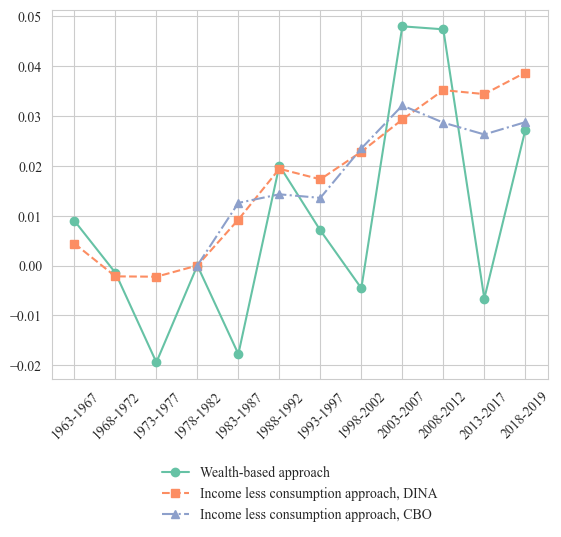

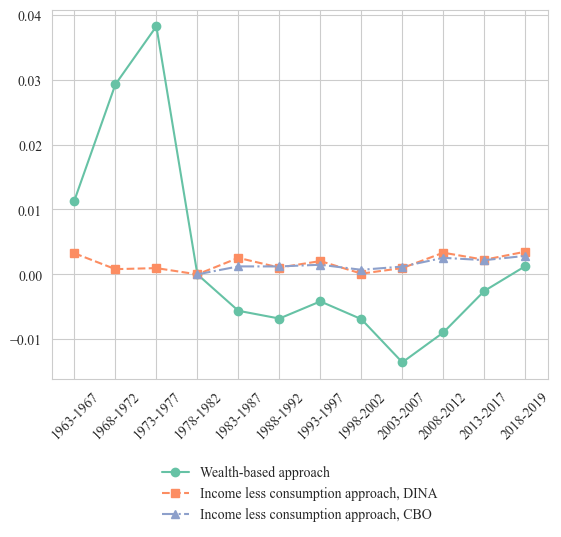

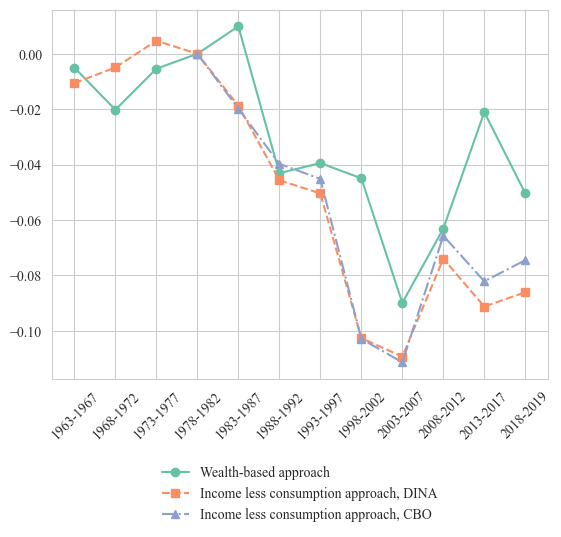

In [18]:
df = get_base_df()
dfs = []
for p in [1,9,90]:
    sub = df[df.Percentile==p].copy()
    df_fig, df_tab = make_figure_table_combo(sub, f'saving{p}')
    dfs.append(df_fig)

## Group by source

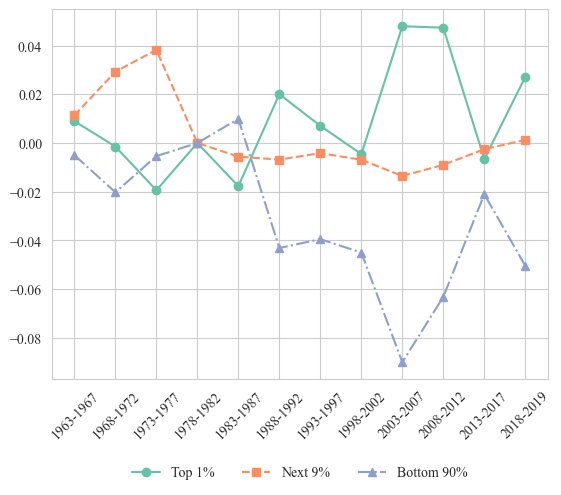

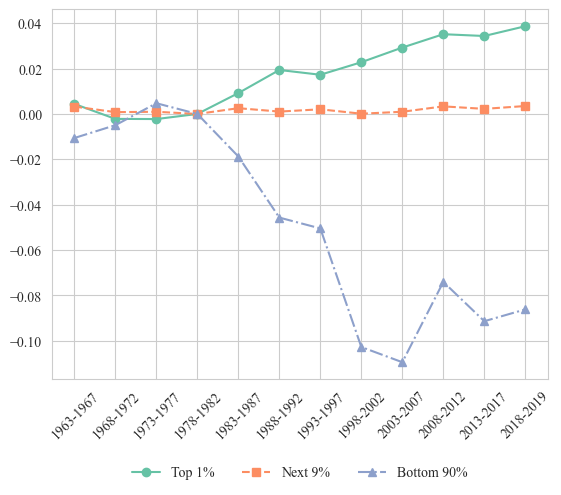

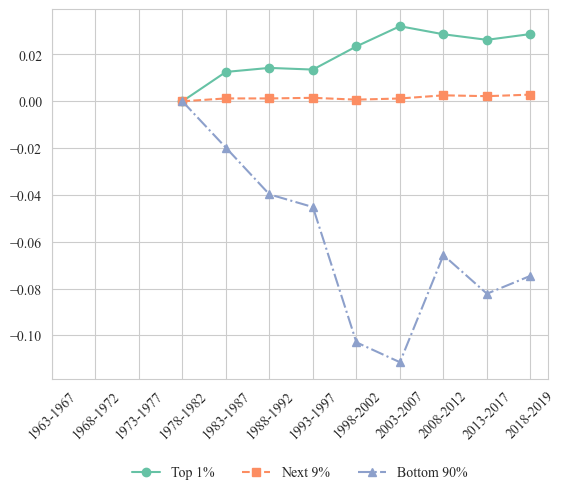

In [19]:
collapsed = pd.concat(dfs)
for i, col in enumerate(['FOFsaving2NI', 'DINAsaving2NI','CBOsaving2NI']):
    fig, ax = plt.subplots()
    
    for j, p in enumerate([1,9,90]):
        ax.plot(collapsed[collapsed.Percentile==p].Year, collapsed[collapsed.Percentile==p][f'{col}_diff'], label=percentile_labels[p], linestyle=linestyles[j], marker=markers[j])

    ax.set_xticks(df_fig.Year)
    ax.set_xticklabels(df_fig.Year_Group, rotation=45)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False)
    plt.savefig(os.path.join(figures_folder, f'{col}_by_percentile.png'), dpi=300, bbox_inches='tight')

# Investment statistics

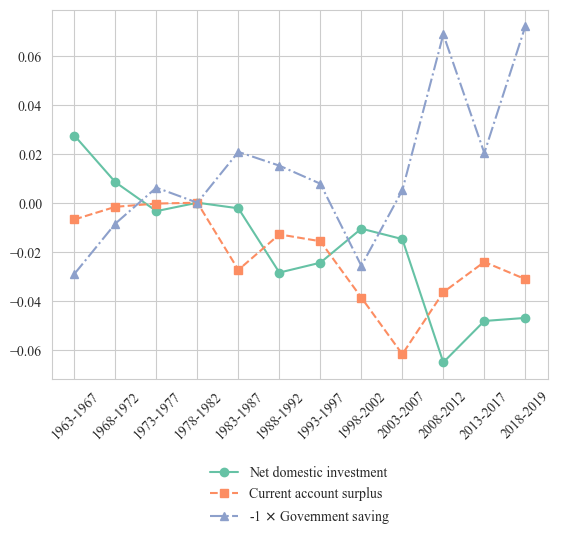

In [20]:
nipa = load_nipa_tables()
_ = make_figure_table_combo(nipa, 'traditional_absorption', cols=['NetInvDomestic2NI','NetExGoodsAndServicesROW2NI','GovDeficit2NI'], labels = ['Net domestic investment', 'Current account surplus', r'-1 $\times$ Government saving'], col_dict = {'NetInvDomestic2NI':r'$I^n$', 'NetExGoodsAndServicesROW2NI':r'$F$', 'GovDeficit2NI':r'$-S^g$'})

# Saving within cohort

In [21]:
df = load_data('Yjhscfplus.dta', folder=os.path.join('raw','mss2021jh'))

In [22]:
df['sav_10'] = df[[col for col in df.columns if re.search('^sav..._10$', col)]].sum(axis=1)
df['sav_90'] = df[[col for col in df.columns if re.search('^sav..._(4|5)0$', col)]].sum(axis=1)

In [23]:
df = df.sort_values(by='year')
df['yearlag'] = df['year'].shift() + 1

df = df[~df.yeargroup.isna()]

df['first_year'] = df.groupby(['yeargroup'])['yearlag'].transform('first').astype(int)
df['last_year'] = df.groupby(['yeargroup'])['year'].transform('last').astype(int)
df['yearlabel'] = df['first_year'].astype(str) + '-' + df['last_year'].astype(str)

In [24]:
df = df.groupby(['yeargroup', 'yearlabel'])[['sav_10','sav_90']].mean().reset_index()

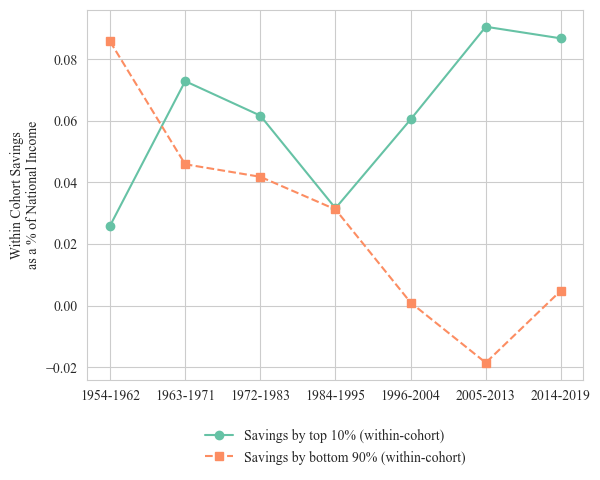

In [25]:
fig, ax = plt.subplots()

labels = {
    10 : 'Savings by top 10% (within-cohort)',
    90 : 'Savings by bottom 90% (within-cohort)'
}

for i, p in enumerate(labels):
    ax.plot(df.yeargroup, df[f'sav_{p}'], label=labels[p], linestyle=linestyles[i], marker=markers[i])

ax.set_ylabel(f'Within Cohort Savings\nas a % of National Income')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1, frameon=False)

ax.set_xticks(df.yeargroup)
ax.set_xticklabels(df.yearlabel)

file_name = 'within_cohort_savings.png'
plt.savefig(os.path.join(figures_folder, file_name), dpi=300, bbox_inches='tight')

# Absorption of accumulated savings

In [26]:
df = get_base_df()
nipa = load_nipa_tables()

df = df[df.Year>=1973]

nipa_cols = ['NetExGoodsAndServicesROW2NI','NetInvDomestic2NI','GovSaving2NI','StatisticalDiscrepancy2NI']
fof_cols = ['Top1Saving2NI', 'Bottom99Saving2NI']

cols = [fof_cols[0]] + nipa_cols[:2] + [fof_cols[1]] + nipa_cols[2:] # Re-order columns

# Combine bottom 99% 
df.loc[df.Percentile!=1, 'Percentile'] = 99
df = df.groupby(['Year','Percentile'], observed=True).sum().reset_index()
df = df.pivot_table(values='FOFsaving2NI', index='Year', columns='Percentile').reset_index().rename(columns={1:fof_cols[0], 99:fof_cols[1]})
df = df.merge(nipa[['Year']+nipa_cols], on='Year')

# Invert investment and foreign account so that everything sums to 0
for col in ['NetInvDomestic2NI','NetExGoodsAndServicesROW2NI']:
    df[col] *= -1
    
# Set discrepancy so that sum is 0
df['StatisticalDiscrepancy2NI'] = -df[cols[:-1]].sum(axis=1)

In [27]:
# Take mean of pre-1982 
df.loc[df.Year<=1982, 'Year_Group'] = '1973-1982'
df.loc[df.Year>1982, 'Year_Group'] = df['Year'].astype(str)
df = df.groupby(['Year_Group']).mean().reset_index()

# Difference relative to base period and get sum of savings
df = take_difference(df, base_year='1973-1982', cols=cols)
df_sums = df[[col for col in df.columns if col.endswith('_diff')]].sum()

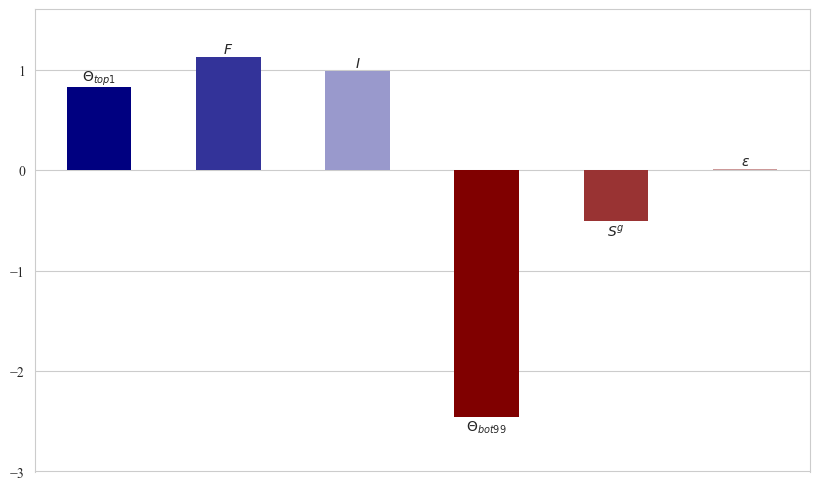

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = [lighten_color(color, amount) for color in ['navy','maroon'] for amount in [1,0.8,0.4]]
bars = df_sums.plot(kind='bar', ax=ax, color=colors, linewidth=0)
ax.set_xticklabels([], rotation=0)
ax.set_ylim([-3,1.6])
ax.grid(axis='x')

labels = [r'$\Theta_{top1}$', r'$F$', r'$I$', r'$\Theta_{bot99}$', r'$S^g$', r'$\epsilon$']
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    if height<0:
        height -= 0.18
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X coordinate of the text
        height,  # Y coordinate of the text
        f'{labels[i]}',  # Text to display
        ha='center',  # Horizontal alignment
        va='bottom'  # Vertical alignment
    )

plt.savefig(os.path.join(figures_folder, f'absorption_of_savings.png'), dpi=300, bbox_inches='tight')

# Valuation effects

In [29]:
df = get_base_df()
for p in [1,9,90]:
    sub = df[df.Percentile==p].copy()
    df_fig, df_tab = make_figure_table_combo(sub, f'valuation{p}', cols=['FOFsaving2NI','d_Wealth2NI','Valuation2NI'], labels = ['Savings', 'Change in net worth', 'Valuation gains'], col_dict = {'FOFsaving2NI':r'$\Theta$', 'd_Wealth2NI':r'$\Delta NW$', 'Valuation2NI':r'$\Delta V$'}, make_figure=False)

# Decomposing savings

In [30]:
def decompose_savings(df, group='Asset Type', name='decomposition', cols=['Tot Saving','Financial Asset','Real Estate','Liability'], labels=['Total savings', 'Savings in financial assets', 'Savings in real estate', 'Savings in liabilities'], col_dict={'Tot Saving':r'$\Theta$', 'Financial Asset':r'$\Theta^{FA}$', 'Real Estate':r'$\Theta^{RE}$', 'Liability':r'$D$'}):
     
    df = df.groupby(['Year','Percentile',group], observed=True)['FOFsaving2NI'].sum().reset_index()
    df = df.pivot_table(values='FOFsaving2NI', index=['Year', 'Percentile'], columns=group).reset_index()
    df['Tot Saving'] = df[[col for col in cols if col!='Tot Saving']].sum(axis=1)
    
    for p in [1,9,90]:
        sub = df[df.Percentile==p].copy()
        _, _ = make_figure_table_combo(sub, f'{name}{p}', cols=cols, labels=labels, col_dict=col_dict, make_figure=False)

In [31]:
df = load_data('fof_savings_by_asset.csv')

In [32]:
decompose_savings(df)

In [33]:
# TODO: Use finer bins

# Unveiling results

## Unveiled wealth by instrument

In [34]:
def make_stack_plot(df, asset_name='Households and Nonprofit Organizations', groups=[], palette='Paired'):
    df = df[df['Primary Asset']==asset_name]
    
    fig, ax = plt.subplots()
    
    x = df.Year
    y = df[groups].values.T
    
    colors = sns.color_palette(palette, n_colors=len(groups))
    
    ax.stackplot(x, y, labels=groups, colors=colors)
    ax.legend(loc='upper left', frameon=False, prop={'size': 'small'},  ncol=2)
    
    ax.set_xlim([df.Year.min(), df.Year.max()])
    ax.set_ylabel(f'{asset_name} Debt Held\nas a % of National Income')
    
    file_name = asset_name.replace(' ','_').lower() +'_stackplot.png'
    plt.savefig(os.path.join(figures_folder, file_name), dpi=300, bbox_inches='tight')
    

In [35]:
asset_names = ['Households and Nonprofit Organizations','Federal Government','Nonfinancial Non-Corporate Business','Nonfinancial Corporate Business']
df = load_data('unveiled_by_instrument.csv')

# Map instruments into larger bins
d = {
    'Depository and Cash':['Checkable Deposits and Currency', 'Time and Savings Deposits','Treasury Securities', 'Money Market Fund Shares'],
    'Corporate':['Corporate Equities', 'Corporate and Foreign Bonds','Mutual Fund Shares'],
    'Non-Corporate':["Proprietors' Equity in Noncorporate Business"],
    'Pass-Through':['Agency- and GSE-Backed Securities'],
    'Insurance':['Pension Entitlements','Life Insurance Reserves'],
    'Other Assets':['Municipal Securities','Other Loans and Advances','U.S. Official Reserve Assets and SDR Allocations','Non-Financial Assets','U.S. Deposits in Foreign Countries','Consumer Credit','Federal Funds and Security Repurchase Agreements','Net Interbank Transactions','Taxes Payable by Businesses','Open Market Paper','Direct Investment','Home Mortgages','Commercial Mortgages','Multifamily Residential Mortgages','Farm Mortgages','Trade Credit','Identified Miscellaneous Financial Claims - Part I','Identified Miscellaneous Financial Claims - Part II','Unidentified Miscellaneous Financial Claims']
}

# Restructure dictionary
instrument_dict = {}
for key, values in d.items():
    for value in values:
        instrument_dict[value] = key

# Collapse into groups
df['Instrument (Large)'] = df.apply(lambda row: instrument_dict[row.Instrument], axis=1)
df.loc[df['Final Holder']!='Households and Nonprofit Organizations', 'Group'] = df['Final Holder']
df.loc[df['Final Holder']=='Households and Nonprofit Organizations', 'Group'] = df['Instrument (Large)']

groups = list(d.keys()) + [s for s in df.Group.unique() if s in df['Final Holder'].unique()]

df = df.groupby(['Primary Asset','Group','Year'])['Amount'].sum().reset_index()

# Rescale by national income
df = df.merge(natinc, on='Year')
df['Wealth2NI'] = df['Amount']/df['NationalInc']

df = df.pivot_table(values='Wealth2NI', index=['Primary Asset','Year'], columns='Group').reset_index()
df = df.fillna(0)

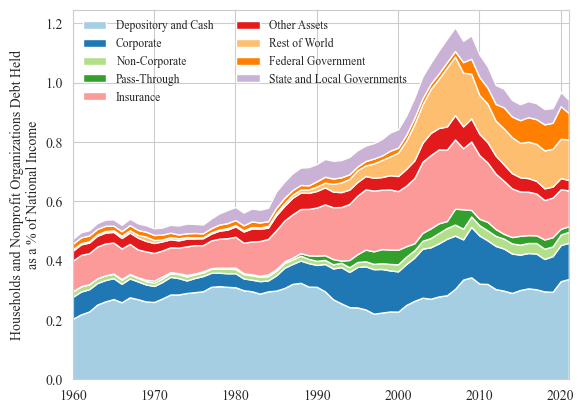

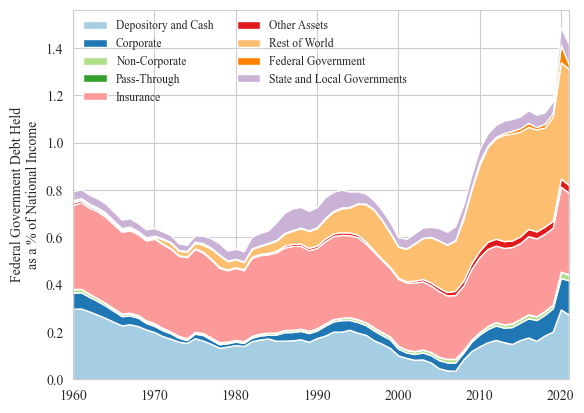

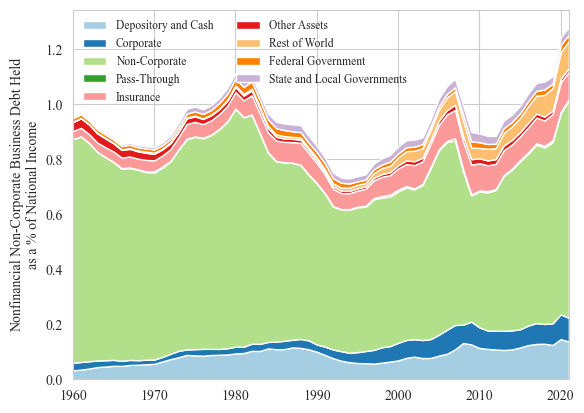

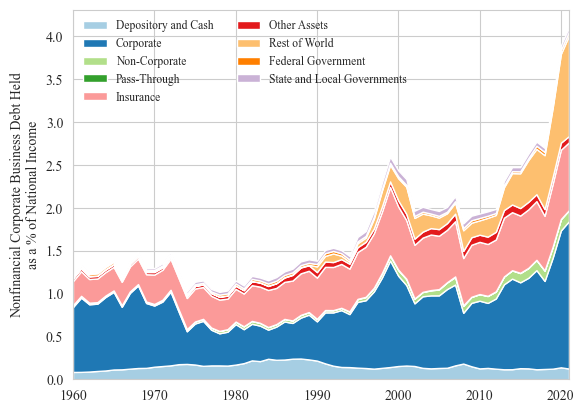

In [36]:
for asset in asset_names:
    make_stack_plot(df, groups=groups, asset_name=asset)

## Unveiled wealth by percentile

In [37]:
def plot_unveiled_percetiles(df, asset_name='', col_name='DINAWealth2NI'):
    df = df[df['Primary Asset']==asset_name]
    
    fig, ax = plt.subplots()
    
    for p in [1,9,90]:
        ax.plot(df[df.Percentile==p].Year, df[df.Percentile==p][col_name], label=percentile_labels[p])
        
    ax.set_ylabel(f'{asset_name} Debt Held\nas a % of National Income')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)
    
    file_name = asset_name.replace(' ','_').lower() +'_percentiledist.png'
    plt.savefig(os.path.join(figures_folder, file_name), dpi=300, bbox_inches='tight')

In [38]:
df = load_data('dina_unveiled.csv')

both = df[df['Primary Asset'].isin(['Households and Nonprofit Organizations','Federal Government'])].groupby(['Percentile','Year','Final Holder'])[['DINAWealth2NI', 'DINAWealth']].sum().reset_index()
both['Primary Asset'] = 'Household and Government'

df = pd.concat([df,both])

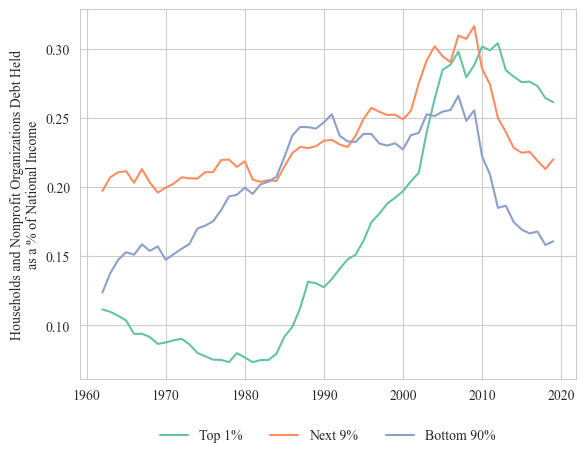

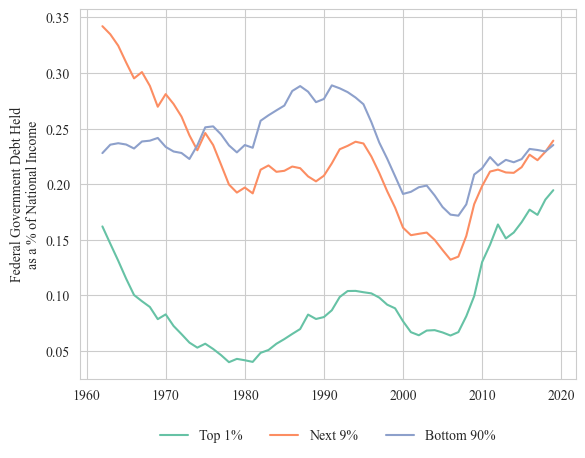

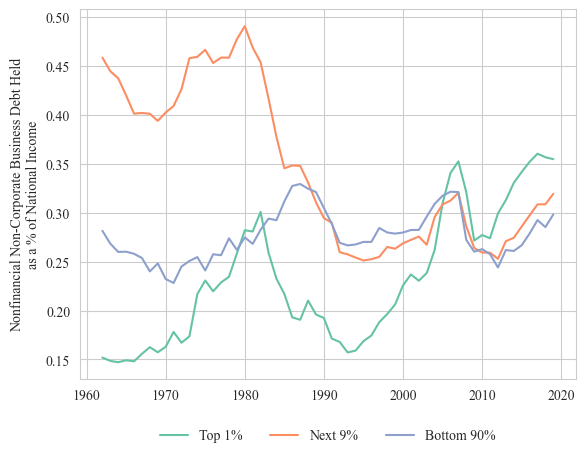

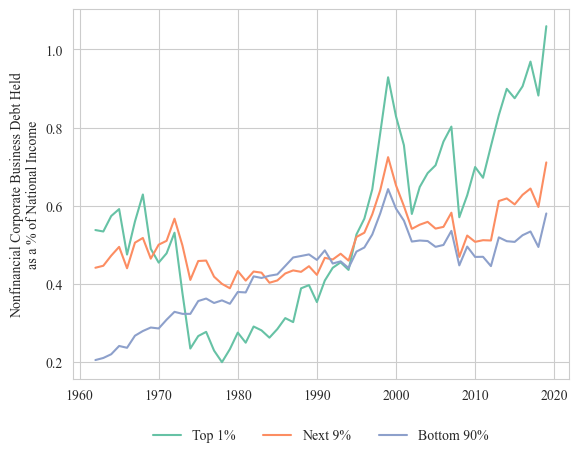

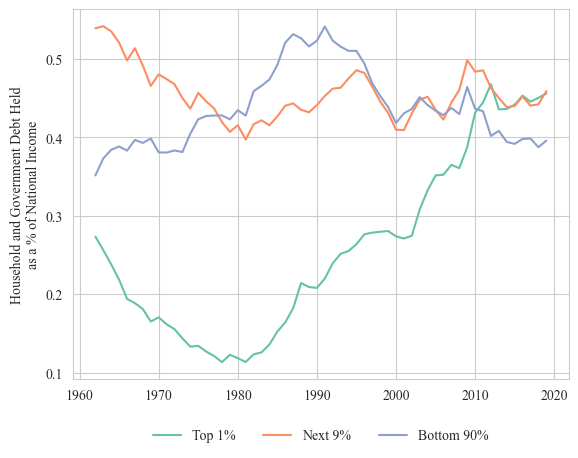

In [39]:
for asset in asset_names + ['Household and Government']:
    plot_unveiled_percetiles(df, asset_name=asset)

In [40]:
df = load_data('dina_unveiled.csv')
df = df.merge(natinc, on='Year')
df['DINAWealth'] = df['DINAWealth2NI'] * df['NationalInc']
df['L_DINAWealth'] = df.groupby(['Primary Asset','Final Holder','Percentile'])['DINAWealth'].shift()
df['d_DINAWealth'] = df['DINAWealth'] - df['L_DINAWealth']
df['d_DINAWealth2NI'] = df['d_DINAWealth']/df['NationalInc']

df = df.pivot_table(values='d_DINAWealth2NI', index=['Year','Percentile'], columns='Primary Asset').reset_index()
df['Total'] = df[df.columns[2:]].sum(axis=1)
df['HH + Gov'] = df['Households and Nonprofit Organizations'] + df['Federal Government']

In [41]:
for p in percentile_labels:
    sub = df[df.Percentile==p].copy()
    _, _ = make_figure_table_combo(sub, f'unveiling{p}', cols=['Total','Households and Nonprofit Organizations','Federal Government', 'HH + Gov'], col_dict = {'Total':r'$\Delta W^{FA}$', 'Households and Nonprofit Organizations':r'$\Delta W^{HHD}$', 'Federal Government':r'$\Delta W^{GOVD}$', 'HH + Gov':r'$\Delta W^{HHD} + \Delta W^{GOVD}$'}, make_figure=False)
    

# Household debt position

In [42]:
# Get assets 
asset = df[['Year','Percentile','Households and Nonprofit Organizations']].rename(columns={'Households and Nonprofit Organizations':r"$\Theta^{HHD}$"})

# Get liabilities
liab = load_data('fof_savings_by_asset.csv')
liab = liab[(liab['Is Asset']==0)&(~liab['Description'].str.contains('IRA'))]
liab[r"$D$"] = liab['FOFsaving2NI']
liab = liab.groupby(['Year', 'Percentile'], observed=True)[r"$D$"].sum().reset_index()

df = asset.merge(liab, on=['Percentile', 'Year'])
df['Percentile'] = df.apply(lambda row: percentile_labels[row.Percentile], axis=1)
df[r"$\Theta^{NHHD}$"] = df[r"$\Theta^{HHD}$"] + df[r"$D$"]

df = df[['Percentile','Year',r"$\Theta^{HHD}$",r"$D$",r"$\Theta^{NHHD}$"]]
df = collapse_data(df, splits=year_splits, groups=['Percentile'])
df = df.drop(columns='Year')
df = df.rename(columns={'Year_Group':'Year'})

df = df.pivot_table(values=[r"$\Theta^{HHD}$", r"$D$", r"$\Theta^{NHHD}$"], index=['Year'], columns='Percentile', observed=False).reset_index()
df.columns = df.columns.swaplevel(0, 1)
df = df.sort_index(axis=1)

In [43]:
# Convert to latex
latex_str = df.to_latex(index=False, multicolumn_format='c', float_format="%.3f")
latex_str = add_cmidrule(latex_str, df)
latex_str = latex_str.replace('%','\%')
save_table(latex_str, 'net_hhd_position.tex')

# Net Household Debt Level

In [44]:
asset = load_data('dina_unveiled.csv')
asset = asset[asset['Primary Asset']=='Households and Nonprofit Organizations'][['Year','Percentile','DINAWealth2NI']].rename(columns={'DINAWealth2NI':'HHDAsset2NI'})

liab = load_data('fof_savings_by_asset.csv')
liab = liab[(liab['Is Asset']==0)&(liab['Description'].isin(['Consumer Credit', 'Home Mortgages']))]
liab['HHDLiab2NI'] = liab['Amount']/liab['NationalInc']
liab = liab.groupby(['Year', 'Percentile'], observed=True)['HHDLiab2NI'].sum().reset_index()

df = asset.merge(liab, on=['Year','Percentile'])
df['HHDNet2NI'] = df['HHDAsset2NI'] + df['HHDLiab2NI']

# Difference relative to 1982
df = take_difference(df, base_year=1982, groups=['Percentile'], cols=['HHDNet2NI'], year_col='Year')

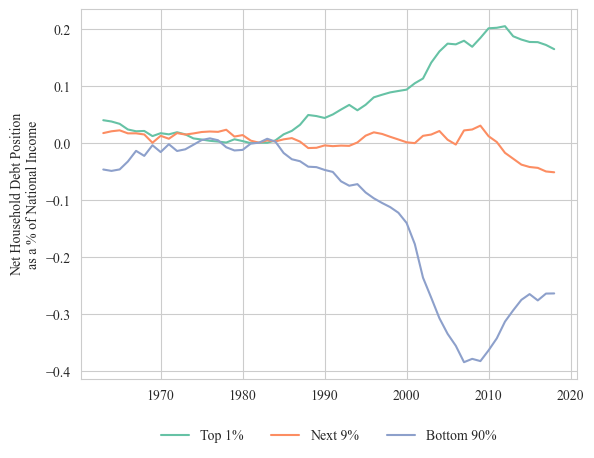

In [45]:
fig, ax = plt.subplots()

for p in percentile_labels:
    ax.plot(df[df.Percentile==p].Year, df[df.Percentile==p].HHDNet2NI_diff, label=percentile_labels[p])

ax.set_ylabel(f'Net Household Debt Position\nas a % of National Income')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)

file_name = 'net_hhd_position.png'
plt.savefig(os.path.join(figures_folder, file_name), dpi=300, bbox_inches='tight')

# Sources of debt financing

In [46]:
unveiled = load_data('unveiled.csv')

# Add in total
summary = unveiled.groupby(['Year','Primary Asset'])['Amount'].sum().reset_index()
summary['Final Holder'] = 'Total'
unveiled = pd.concat([unveiled, summary], ignore_index=True)

unveiled['Percentile'] = 100
unveiled = unveiled[unveiled['Final Holder']!='Households and Nonprofit Organizations']

unveiled_dina = load_data('dina_unveiled.csv').rename(columns={'DINAWealth':'Amount'})

In [47]:
dfs = []
for df in [unveiled, unveiled_dina]:
    
    # Collapse household and government debt
    df = df[df['Primary Asset'].isin(['Federal Government', 'Households and Nonprofit Organizations'])]
    df = df.groupby(['Final Holder', 'Percentile', 'Year'])['Amount'].sum().reset_index()
    
    # Generate savings to national income
    df = df.merge(natinc, on='Year')
    df['L_Amount'] = df.groupby(['Final Holder','Percentile'])['Amount'].shift() 
    df['Sav2NI'] = (df['Amount'] - df['L_Amount'])/df['NationalInc']
    df['Hold2NI'] = df['Amount']/df['NationalInc']
     
    dfs.append(df)
    
df = pd.concat(dfs)
df['Final Holder'] = df.apply(lambda row: percentile_labels[row.Percentile] if row.Percentile!=100 else row['Final Holder'], axis=1)

## Timeseries

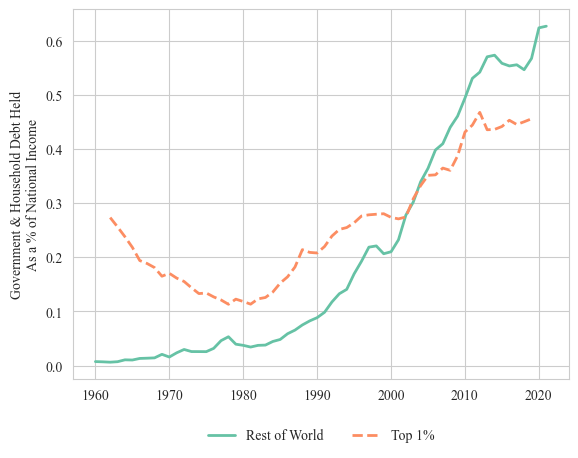

In [48]:
fig, ax = plt.subplots()

for i, holder in enumerate(['Rest of World', 'Top 1%']):
    ax.plot(df[df['Final Holder']==holder].Year, df[df['Final Holder']==holder].Hold2NI, label=holder,linestyle=linestyles[i], linewidth=2)

ax.set_ylabel('Government & Household Debt Held\nAs a % of National Income')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)

plt.savefig(os.path.join(figures_folder, f'safe_asset_demand.png'), dpi=300, bbox_inches='tight')

## Collapse

In [49]:
df = collapse_data(df, splits=[1963,1983,2019], groups=['Final Holder'])
df = take_difference(df, base_year='1963-1982', groups=['Final Holder'], cols=['Sav2NI'])
df = df[df.Year_Group=='1983-2018'][['Final Holder', 'Sav2NI_diff']]

In [50]:
df.loc[df['Final Holder']=='Federal Government', 'Final Holder'] = 'Federal\nGov.'
df.loc[df['Final Holder']=='State and Local Governments', 'Final Holder'] = 'State & Local\nGov.'
df.loc[df['Final Holder']=='Rest of World', 'Final Holder'] = 'RoW'

# Re-order
order = ['Total','RoW','Top 1%','Next 9%','Bottom 90%','Federal\nGov.', 'State & Local\nGov.']
# Reorder the dataframe
df['Final Holder'] = pd.Categorical(df['Final Holder'], categories=order, ordered=True)
df = df.sort_values('Final Holder')

In [ ]:
fig, ax = plt.subplots()

ax.bar(df['Final Holder'], df['Sav2NI_diff'], color=sns.color_palette(custom_palette, n_colors=len(df)))
ax.set_ylabel('Average Rise in Government & Household Debt\nAs a % of National Income')

plt.savefig(os.path.join(figures_folder, f'financing_hh_gov_debt.png'), dpi=300, bbox_inches='tight')

# SGR Addendum